# DATA 620 : Week 10 - Document Classification
### by Don Padmaperuma & Gracie Hui Han

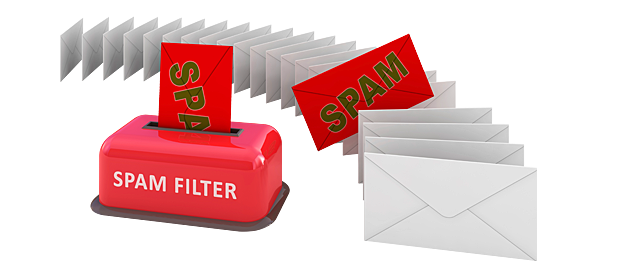



## Assignment Requirements
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

Data Set: http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data


In [39]:
import nltk
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split as tts
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
import sklearn.metrics as sm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr

from xgboost import XGBRegressor

import seaborn as sn

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
spam = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', sep = ",", header = None)
spam.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Rename columns. The column names were taken from the UCI Machine Learning SPAM "names" folder

In [4]:
names = ["word_freq_make", 
 "word_freq_address", 
 "word_freq_all", 
 "word_freq_3d", 
 "word_freq_our", 
 "word_freq_over", 
 "word_freq_remove", 
 "word_freq_internet",
 "word_freq_order",        
 "word_freq_mail",         
 "word_freq_receive",      
 "word_freq_will",     
 "word_freq_people",
 "word_freq_report",       
 "word_freq_addresses",    
 "word_freq_free",       
 "word_freq_business",     
 "word_freq_email",        
 "word_freq_you",         
 "word_freq_credit",       
 "word_freq_your",         
 "word_freq_font",         
 "word_freq_000",          
 "word_freq_money",        
 "word_freq_hp",           
 "word_freq_hpl",          
 "word_freq_george",       
 "word_freq_650",          
 "word_freq_lab",          
 "word_freq_labs",         
 "word_freq_telnet",       
 "word_freq_857",          
 "word_freq_data",         
 "word_freq_415",          
 "word_freq_85",           
 "word_freq_technology",   
 "word_freq_1999",         
 "word_freq_parts",        
 "word_freq_pm",           
 "word_freq_direct",       
 "word_freq_cs",           
 "word_freq_meeting",      
 "word_freq_original",     
 "word_freq_project",      
 "word_freq_re",           
 "word_freq_edu",          
 "word_freq_table",        
 "word_freq_conference",   
 "char_freq_;",            
 "char_freq_(",            
 "char_freq_[",            
 "char_freq_!",            
 "char_freq_$",            
 "char_freq_#",            
 "capital_run_length_average",
 "capital_run_length_longest",
 "capital_run_length_total",
 "spam"]
spam.columns = names

In [5]:
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


# Data Exploration

In [6]:
print("Content of this dataset: " + str(spam.shape[0]) + " rows and " + str(spam.shape[1]) + " columns")

Content of this dataset: 4601 rows and 58 columns


In [7]:
# Column wise statistics of data
spam.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,0.059824,0.541702,0.093930,0.058626,0.049205,0.248848,0.142586,0.184745,1.662100,0.085577,0.809761,0.121202,0.101645,0.094269,0.549504,0.265384,0.767305,0.124845,0.098915,0.102852,0.064753,0.047048,0.097229,0.047835,0.105412,0.097477,0.136953,0.013201,0.078629,0.064834,0.043667,0.132339,0.046099,0.079196,0.301224,0.179824,0.005444,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,0.201545,0.861698,0.301036,0.335184,0.258843,0.825792,0.444055,0.531122,1.775481,0.509767,1.200810,1.025756,0.350286,0.442636,1.671349,0.886955,3.367292,0.538576,0.593327,0.456682,0.403393,0.328559,0.555907,0.329445,0.532260,0.402623,0.423451,0.220651,0.434672,0.349916,0.361205,0.766819,0.223812,0.621976,1.011687,0.911119,0.076274,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

# Spam and Non Spam (Ham) Count
Last colunm of the dataset shows if the corresponding raw represents a spam or a non spam. In other words Ham. **"1"** represents Spam while **"0"** represent Ham.

In [8]:
spam_column = len(spam[spam.spam == 1])
notspam_column = len(spam[spam.spam == 0])

print("Spam data count: %d" %spam_column)
print("Non spam or Ham data count: %d" %notspam_column)

Spam data count: 1813
Non spam or Ham data count: 2788


In [9]:
# Checking for nulls - We see that there are no nulls in the dataset
spam[spam.isnull().any(axis = 1)]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam


In [11]:
# Counting number of Spam/Non-Spam samples in the database
spam.groupby('spam').count()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
spam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788
1,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813,1813


# Data Preparation
Train and Test Set

In [33]:
# Splitting the data into training and testing subsets

X = spam.iloc[:, :-1]
y = spam.spam

# Removing special characters from column names, else it creates a problem using various regression models
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

# Building Models

# Naive Bayes Classifier
Building a MultinomialNB Classifier model using training subset and then testing the effectiveness of model on test set.

In [34]:
# Using MultinomialNB Classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

predicted = mnb.predict(X_test)

score = accuracy_score(y_test, predicted)
print('Accuracy Score: \n', (100*score))

Accuracy Score: 
 80.95582910934105


We have achieved 81% of accuracy with Multinomial Naive Bayes Classifier. It is a good number but not the best. This still means there's a 20% of emails have misclassified. In that case it is important to avoid the False - Positive Classification which means that classifying non-spam email as spam email.


Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       822
           1       0.77      0.75      0.76       559

    accuracy                           0.81      1381
   macro avg       0.80      0.80      0.80      1381
weighted avg       0.81      0.81      0.81      1381



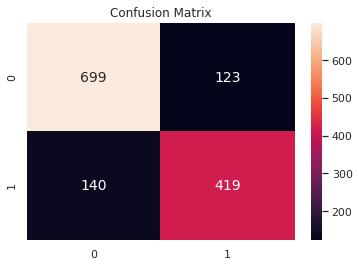

In [35]:
# Creating a confusion matrix and Classification Report.
cm1 = cm(y_test, predicted, labels=[0, 1])
df_cm = pd.DataFrame(cm1, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')

print('\nClassification Report: \n', cr(y_test, predicted))

Based on the graph we can say about 10% is our False - Positive classification shows that it is possible to have very important emails end up in spam folder. 

# XGBoost Model
Creating an XGBoost model with training set, testing on test set and printing out the classification report and confusion matrix. XGBoost considered as much more sophisticated compared to our previous classifier and an ensembel of random forest classifier. 

In [36]:
xgb = XGBRegressor(n_estimators=120, leanring_rate=0.075)
#xgb.fit(X_train, y_train)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

predicted1 = xgb.predict(X_test)

[02:49:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Accuracy Score on XGBoost: 
 93.26574945691529

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       822
           1       0.95      0.88      0.91       559

    accuracy                           0.93      1381
   macro avg       0.94      0.92      0.93      1381
weighted avg       0.93      0.93      0.93      1381



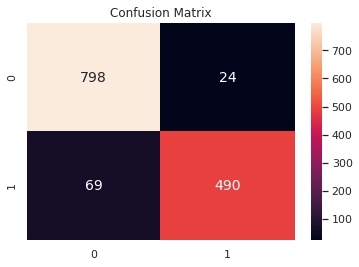

In [37]:
# Predicting when False Outcomes are Allowed for probabilities >0.5
score1 = accuracy_score(y_test, (predicted1 > 0.5))
print('Accuracy Score on XGBoost: \n', (100*score1))
cm2 = cm(y_test, predicted1 > 0.5, labels=[0, 1])
df_cm = pd.DataFrame(cm2, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
print('\nClassification Report: \n', cr(y_test, (predicted1 > 0.5)))

This time with XGBoost regresser we were able to achieve less than 4% False - Positive classification. This is an improvement from our previous classification with the accuracy rate of 93%. Even with a higher percentage, it is not acceptable to have Non-spam or Ham email get marked as spam. In order to achive a better result we can do a small change to the above classifier. We can change the probability limit to 0.9.

Accuracy Score on XGBoost: 
 84.06951484431572

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       822
           1       0.99      0.61      0.76       559

    accuracy                           0.84      1381
   macro avg       0.89      0.80      0.82      1381
weighted avg       0.87      0.84      0.83      1381



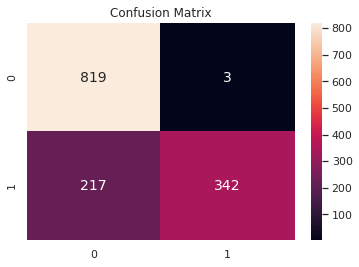

In [38]:
# Predicting when False Outcomes are Allowed for probabilities >0.9
score1 = accuracy_score(y_test, (predicted1 > 0.9))
print('Accuracy Score on XGBoost: \n', (100*score1))
cm2 = cm(y_test, predicted1 > 0.9, labels=[0, 1])
df_cm = pd.DataFrame(cm2, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
print('\nClassification Report: \n', cr(y_test, (predicted1 > 0.9)))

With this analysis we have achieved a lesser accuracy percentage but we managed to get our False - Positive classification to down with just 3 Non-spam misclassifications. 

# Conclusion
Two different algorithems such as Naive Bayes and XGBoost gave us different results in this classificaiton. Based on our findings we can say that XGBoost works better than Naive Bayes when classifying Spam emails. 

# Reference

https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

https://www.kdnuggets.com/2017/03/email-spam-filtering-an-implementation-with-python-and-scikit-learn.html


